In [ ]:
# 0. 라이브러리 임포트
#pip install opencv-python

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from tqdm import tqdm
from glob import glob
import gc
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import math
import zipfile
from tqdm.auto import tqdm
import concurrent.futures
import functools

In [3]:
# 1. 데이터셋 준비
# 구글 드라이브 연동

from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
# 이미지 파일 목록 불러오기

train_csv = pd.read_csv('/content/gdrive/MyDrive/dacon_camera/data/train.csv')
test_csv = pd.read_csv('/content/gdrive/MyDrive/dacon_camera/data/test.csv')

In [5]:
train_csv.head()

,img_id,input_img,label_img
0,10000,train_input_10000.png,train_label_10000.png
1,10001,train_input_10001.png,train_label_10001.png
2,10002,train_input_10002.png,train_label_10002.png
3,10003,train_input_10003.png,train_label_10003.png
4,10004,train_input_10004.png,train_label_10004.png


In [6]:
test_csv

,img_id,input_img,submission_name
0,20000,test_input_20000.png,test_20000.png
1,20001,test_input_20001.png,test_20001.png
2,20002,test_input_20002.png,test_20002.png
3,20003,test_input_20003.png,test_20003.png
4,20004,test_input_20004.png,test_20004.png
5,20005,test_input_20005.png,test_20005.png
6,20006,test_input_20006.png,test_20006.png
7,20007,test_input_20007.png,test_20007.png
8,20008,test_input_20008.png,test_20008.png
9,20009,test_input_20009.png,test_20009.png


In [7]:
len(train_csv), len(test_csv)

(622, 20)

In [8]:
train_all_input_files = '/content/gdrive/MyDrive/dacon_camera/data/train_input_img/'+train_csv['input_img']
train_all_label_files = '/content/gdrive/MyDrive/dacon_camera/data/train_label_img/'+train_csv['label_img']
# 파일이름 + 경로

In [9]:
train_all_input_files

0      /content/gdrive/MyDrive/dacon_camera/data/trai...
1      /content/gdrive/MyDrive/dacon_camera/data/trai...
2      /content/gdrive/MyDrive/dacon_camera/data/trai...
3      /content/gdrive/MyDrive/dacon_camera/data/trai...
4      /content/gdrive/MyDrive/dacon_camera/data/trai...
                             ...                        
617    /content/gdrive/MyDrive/dacon_camera/data/trai...
618    /content/gdrive/MyDrive/dacon_camera/data/trai...
619    /content/gdrive/MyDrive/dacon_camera/data/trai...
620    /content/gdrive/MyDrive/dacon_camera/data/trai...
621    /content/gdrive/MyDrive/dacon_camera/data/trai...
Name: input_img, Length: 622, dtype: object

In [10]:
len(train_all_input_files), len(train_all_label_files)

(622, 622)

In [11]:
train_all_input_files[0], train_all_label_files[0]

('/content/gdrive/MyDrive/dacon_camera/data/train_input_img/train_input_10000.png',
 '/content/gdrive/MyDrive/dacon_camera/data/train_label_img/train_label_10000.png')

In [12]:
train_input_files = train_all_input_files[60:]
train_label_files = train_all_label_files[60:]
#테스트용

val_input_files = train_all_input_files[:60]
val_label_files = train_all_label_files[:60]
#검증용

type(train_input_files), len(train_input_files)

(pandas.core.series.Series, 562)

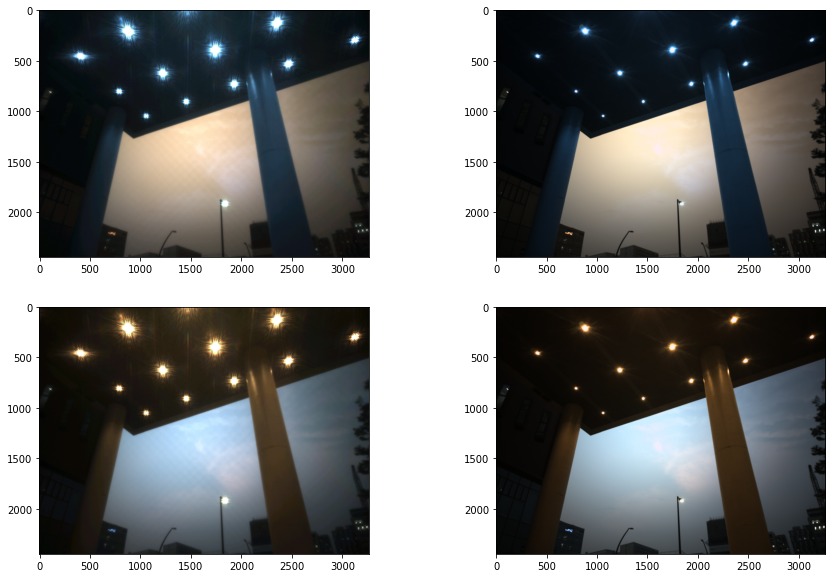

/content/gdrive/MyDrive/dacon_camera/data/train_input_img/train_input_10060.png /content/gdrive/MyDrive/dacon_camera/data/train_label_img/train_label_10060.png 



In [13]:
for input_path, label_path in zip(train_input_files, train_label_files):
    inp_img = cv2.imread(input_path)
    targ_img = cv2.imread(label_path)
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.imshow(inp_img)
    plt.subplot(2,2,2)
    plt.imshow(targ_img)
    # 이미지 읽고, 
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
    targ_img = cv2.cvtColor(targ_img, cv2.COLOR_BGR2RGB)
    # 색상공간 변화
    plt.subplot(2,2,3)
    plt.imshow(inp_img)
    plt.subplot(2,2,4)
    plt.imshow(targ_img)
    plt.show()
    # 출력
    print(input_path, label_path, '\n')
    break

In [14]:
BATCH_SIZE = 8
img_size = 256
#weights = None
weights = 'imagenet'
learning_rate = 1e-5
EPOCHS = 5
dropout_rate = 0.1

In [15]:
img = cv2.imread('/content/gdrive/MyDrive/dacon_camera/data/train_input_img/train_input_10060.png')
img.shape

(2448, 3264, 3)

In [16]:
SAVE_TRAIN_INPUT_PATH = '/content/gdrive/MyDrive/dacon_camera/data/train_input_img_'
SAVE_TRAIN_LABEL_PATH = '/content/gdrive/MyDrive/dacon_camera/data/train_label_img_'

SAVE_VAL_INPUT_PATH = '/content/gdrive/MyDrive/dacon_camera/data/val_input_img_'
SAVE_VAL_LABEL_PATH = '/content/gdrive/MyDrive/dacon_camera/data/val_label_img_'
IMG_SIZE = 256

os.makedirs(f'{SAVE_TRAIN_INPUT_PATH}{IMG_SIZE}', exist_ok=True)
os.makedirs(f'{SAVE_TRAIN_LABEL_PATH}{IMG_SIZE}', exist_ok=True)
os.makedirs(f'{SAVE_VAL_INPUT_PATH}{IMG_SIZE}', exist_ok=True)
os.makedirs(f'{SAVE_VAL_LABEL_PATH}{IMG_SIZE}', exist_ok=True)

In [17]:
# 이미지 256 256으로 자르기

def cut_img(save_path, img_path):    
    img = cv2.imread(img_path)
    img_name = os.path.basename(img_path)
    num = 0
    for top in range(0, img.shape[0], STRIDE):
        for left in range(0, img.shape[1], STRIDE):
            piece = np.zeros([IMG_SIZE, IMG_SIZE, 3], np.uint8)
            temp = img[top:top+IMG_SIZE, left:left+IMG_SIZE, :]
            piece[:temp.shape[0], :temp.shape[1], :] = temp
            cv2.imwrite(f'{save_path}{IMG_SIZE}/{num}_{img_name}', piece)            
            # np.save(f'{save_path}{img_size}/{num}.npy', piece)                
            num+=1
    return

In [18]:
# cut_img(train_input_files, '/content/gdrive/MyDrive/dacon_camera/data/train_input_img_', 128)

#cut_img(train_label_files, '/content/gdrive/MyDrive/dacon_camera/data/train_label_img_', 128)
#cut_img(val_input_files, '/content/gdrive/MyDrive/dacon_camera/data/val_input_img_', 128)
#cut_img(val_label_files, '/content/gdrive/MyDrive/dacon_camera/data/val_label_img_', 128)

In [19]:
STRIDE = 256

with concurrent.futures.ProcessPoolExecutor() as executor: # windows local 환경시 max_workers=os.cpu_count()//2
    list(tqdm(
        executor.map(functools.partial(cut_img, SAVE_TRAIN_INPUT_PATH), train_input_files),             
        desc='train input image cut',
        total=len(train_input_files)
    ))
    list(tqdm(
        executor.map(functools.partial(cut_img, SAVE_TRAIN_LABEL_PATH), train_label_files),             
        desc='train label image cut',
        total=len(train_label_files)
    ))
    list(tqdm(
        executor.map(functools.partial(cut_img, SAVE_VAL_INPUT_PATH), val_input_files),             
        desc='val input image cut',
        total=len(val_input_files)
    ))
    list(tqdm(
        executor.map(functools.partial(cut_img, SAVE_VAL_LABEL_PATH), val_label_files),             
        desc='val label image cut',
        total=len(val_label_files)
    ))

In [24]:
train_inp_files = glob(f'/content/gdrive/MyDrive/dacon_camera/data/train_input_img_{img_size}/*.png')
train_targ_files = glob(f'/content/gdrive/MyDrive/dacon_camera/data/train_label_img_{img_size}/*.png')

val_inp_files = glob(f'/content/gdrive/MyDrive/dacon_camera/data/val_input_img_{img_size}/*.png')
val_targ_files = glob(f'/content/gdrive/MyDrive/dacon_camera/data/val_label_img_{img_size}/*.png')


In [25]:
print(len(train_inp_files), len(train_targ_files), len(val_inp_files), len(val_targ_files), type(train_inp_files))
print(train_inp_files[2])

def load(input, label):
  input_image = tf.io.read_file(input)
  input_imabe = tf.image.decode_jpeg(input_image)

  input_image = tf.cast(input_image, tf.float32)

  label_image = tf.io.read_file(label)
  label_image = tf.image.decode_jpeg(label_image)

  label_image = tf.cast(label_image, tf.float32)
  
  return input_image, label_image


# casting to int for matplotlib to show the image
load('/content/gdrive/MyDrive/dacon_camera/data/train_input_img/train_input_10060.png', '/content/gdrive/MyDrive/dacon_camera/data/train_label_img/train_label_10060.png')
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

39810 39810 7800 7800 <class 'list'>
/content/gdrive/MyDrive/dacon_camera/data/train_input_img_256/2_train_input_10060.png


UnimplementedError: ignored

In [ ]:
# normalizing the images to [-1, 1]

def normalize(input, label):
  input_image = (input / 127.5) - 1
  label_image = (label / 127.5) - 1
  
  return input_image, label_image

# 통합 전처리 함수

@tf.function()
def preprocess(input_image, label_image) :

    #resize

    #augmentation 생략

    return input_image, label_image

# 데이터 불러오기

def load_image_train(input, label):
  input_image, label_image = load(input, label)
  input_image, label_image = preprocess(input_image, label_image)
  input_image, label_image = normalize(input_image, label_image)

  return input_image, label_image

def load_image_test(input, label):
  input_image, label_image = load(input, label)
  input_image, label_image = normalize(input_image, label_image)

  return input_image, label_image

In [ ]:
# 2. 입력 파이프라인 작성

train_dataset = tf.data.Dataset.from_tensor_slices((train_inp_files, train_targ_files))
# numpy 배열을 tf에 넣음. feature와 label을 한 번에 넣을 수 있다.
train_dataset = train_dataset.map(lambda item1, item2: load_image_train(item1, item2), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_inp_files, val_targ_files))
val_dataset = val_dataset.map(lambda item1, item2: load_image_train(item1, item2), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

train_dataset.element_spec, len(train_dataset)

((TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None)),
 4977)

In [ ]:
 next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape, next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

UnimplementedError: ignored

In [ ]:
# 3. Generator 생성
# 인코더 부분

OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
# 디코더 부분

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
# Gernerator 생성

def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

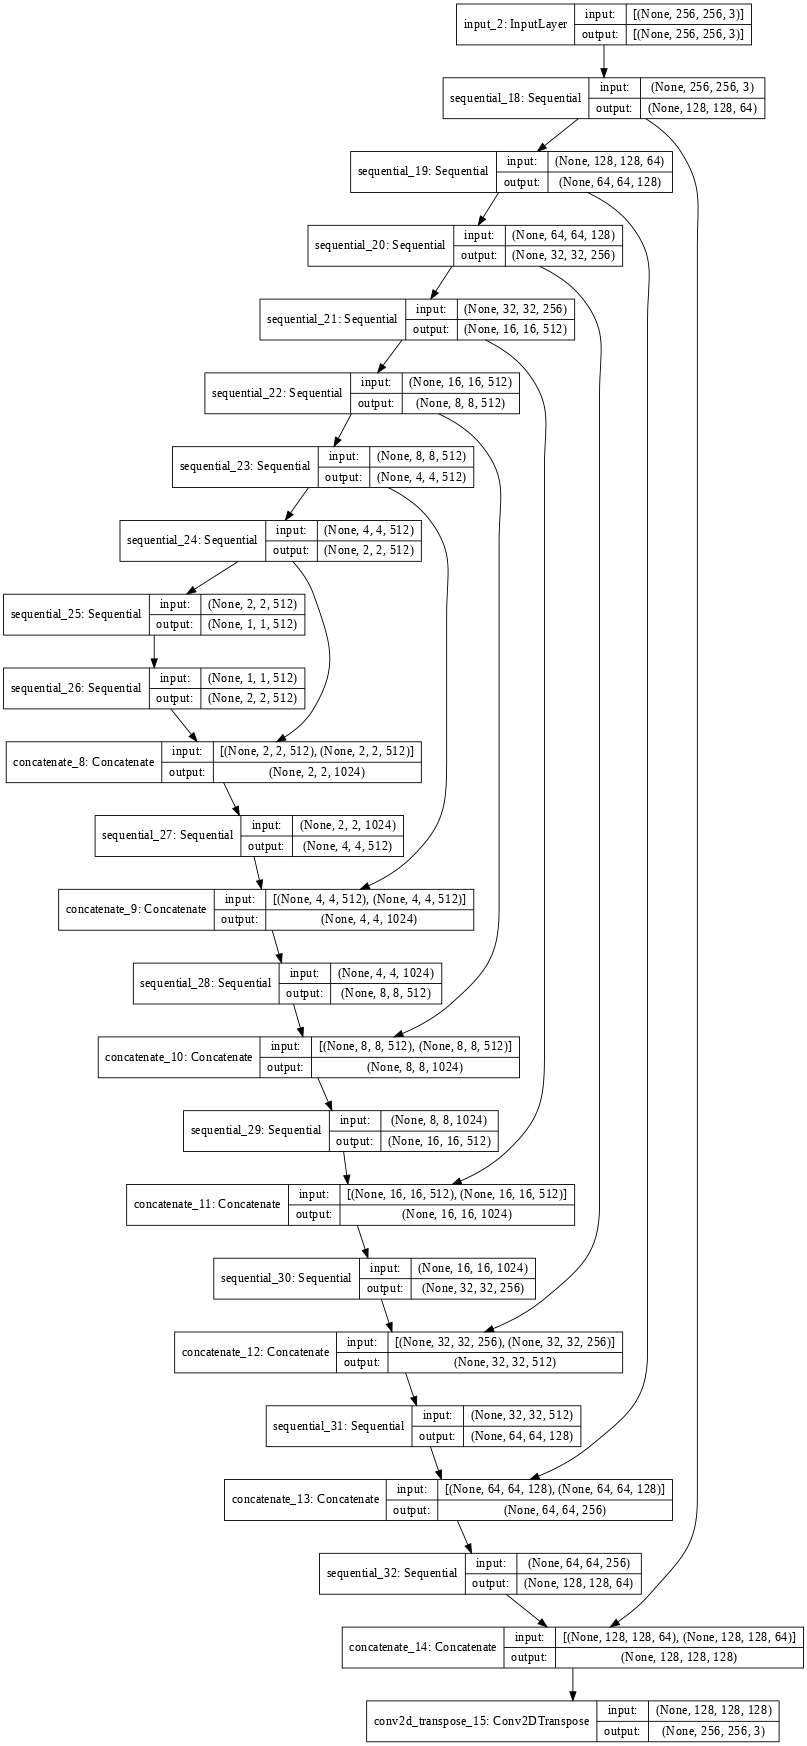

In [ ]:
# 모델 구조 확인

generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
# Generator 손실 함수

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [ ]:
# 4. Discriminator 생성

def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

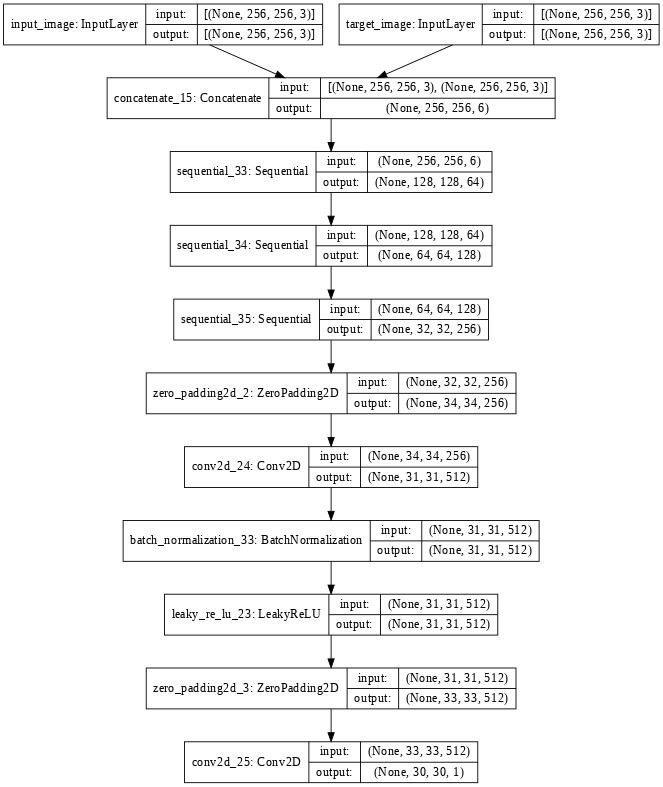

In [ ]:
# 모델 구조 확인

discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
# Discriminator 손실

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
# 5. 준비
# 옵티마이저 설정

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
# 체크포인트 기능

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
# 이미지 생성 유틸

def generate_images(model, test_input):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
# 6. 훈련 준비

EPOCHS = 150

import datetime
log_dir="./logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    print(gen_output.shape)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [ ]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_dataset.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
# 7. 훈련 시작
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}
import time

fit(train_dataset, EPOCHS, val_dataset)

Epoch:  0


ValueError: ignored

In [ ]:
a = [1, 2, 3]
b = [1, a]
print(b)

[1, [1, 2, 3]]
